In [1]:
import numpy as np
from torch import nn

def generate_4x4_data():
  d = 4*4
  basis = 2**np.arange(d)
  numbers = np.arange(2**d)
  binary = (numbers[:,np.newaxis] & basis[np.newaxis,:]) > 0
  assert ((binary * basis).sum(1) == numbers).all()
  return binary.reshape(-1, 4, 4)

def translate_x(data):
  for i in range(4):
    yield np.roll(data, i, axis = 1)

def translate_y(data):
  for i in range(4):
    yield np.roll(data, i, axis = 2)

def rotate(data):
  for i in range(4):
    yield np.rot90(data, k = i, axes = (1, 2))

def mirror(data):
  yield np.flip(data, axis = 1)


reference = generate_4x4_data()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
import numpy as np
from torch import nn

def group_action(fn):
  def apply(data):
    return np.stack([list(fn(data))], axis = 1)
  return apply

@group_action
def null(data):
  yield data
  
@group_action
def translate_x(data):
  for i in range(4):
    yield np.roll(data, i, axis = 1)

@group_action
def translate_y(data):
  for i in range(4):
    yield np.roll(data, i, axis = 2)

@group_action
def rotate(data):
  for i in range(4):
    yield np.rot90(data, k = i, axes = (1, 2))

@group_action
def mirror(data):
  yield np.flip(data, axis = 1)


class Dataset():
  
  def __init__(self):
    self.data, self.basis = self.generate_4x4_data()
    assert np.equal(self.to_index(self.data), np.arange(2**(2*2))).all()

  def to_index(self, data):
    return (data * self.basis).sum((-2,-1))

  def generate_4x4_data(self):
    a = 2
    d = a**2
    basis = 2**np.arange(d)
    numbers = np.arange(2**d)
    binary = (numbers[:,np.newaxis] & basis[np.newaxis,:]) > 0
    assert ((binary * basis).sum(1) == numbers).all()
    binary = binary.reshape(-1, a, a)
    basis = basis.reshape(a, a)
    return binary, basis

  def apply(self, action):
    transformed = action(self.data)
    return self.to_index(transformed)
  
  def __getitem__(self, index):
    return self.data[index]

dataset = Dataset()
print(dataset.data.shape)
dataset.apply(translate_x).shape

(16, 2, 2)


(4, 1, 16)

In [44]:
dataset.apply(translate_x).shape
transformed = translate_x(dataset.data).astype(int)
#print(transformed, transformed.shape)
print(dataset.data.shape)

[[[0 0]
  [0 0]]

 [[1 0]
  [0 0]]

 [[0 1]
  [0 0]]

 [[1 1]
  [0 0]]

 [[0 0]
  [1 0]]

 [[1 0]
  [1 0]]

 [[0 1]
  [1 0]]

 [[1 1]
  [1 0]]

 [[0 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[0 1]
  [0 1]]

 [[1 1]
  [0 1]]

 [[0 0]
  [1 1]]

 [[1 0]
  [1 1]]

 [[0 1]
  [1 1]]

 [[1 1]
  [1 1]]]
(16, 2, 2)


In [22]:
for i in range(10):
    print(i&1, i&2, i&4, i&8)

0 0 0 0
1 0 0 0
0 2 0 0
1 2 0 0
0 0 4 0
1 0 4 0
0 2 4 0
1 2 4 0
0 0 0 8
1 0 0 8


In [27]:
np.set_printoptions(threshold=sys.maxsize)
d = 2*2
basis = 2**np.arange(d)
numbers = np.arange(2**d)

print(basis)
print(numbers)

a = numbers[:,np.newaxis]
b = basis[np.newaxis,:]
print(a, b, a.shape, b.shape)
binary = (a&b > 0).astype(int)
print(binary)

[1 2 4 8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]] [[1 2 4 8]] (16, 1) (1, 4)
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 1 0]
 [0 0 0 1]
 [1 0 0 1]
 [0 1 0 1]
 [1 1 0 1]
 [0 0 1 1]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 1]]


(65536, 4)


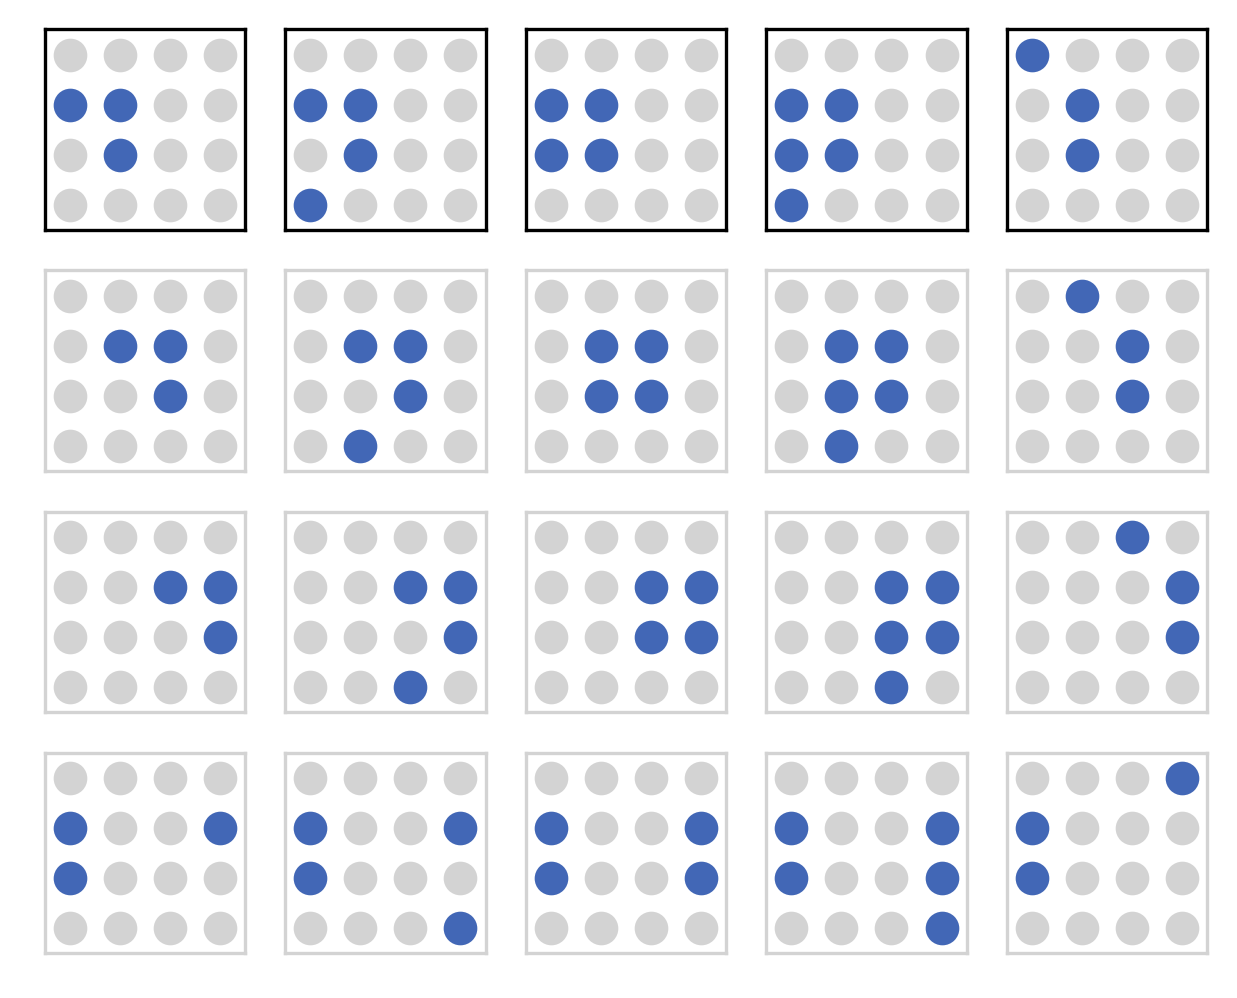

(65536, 4)


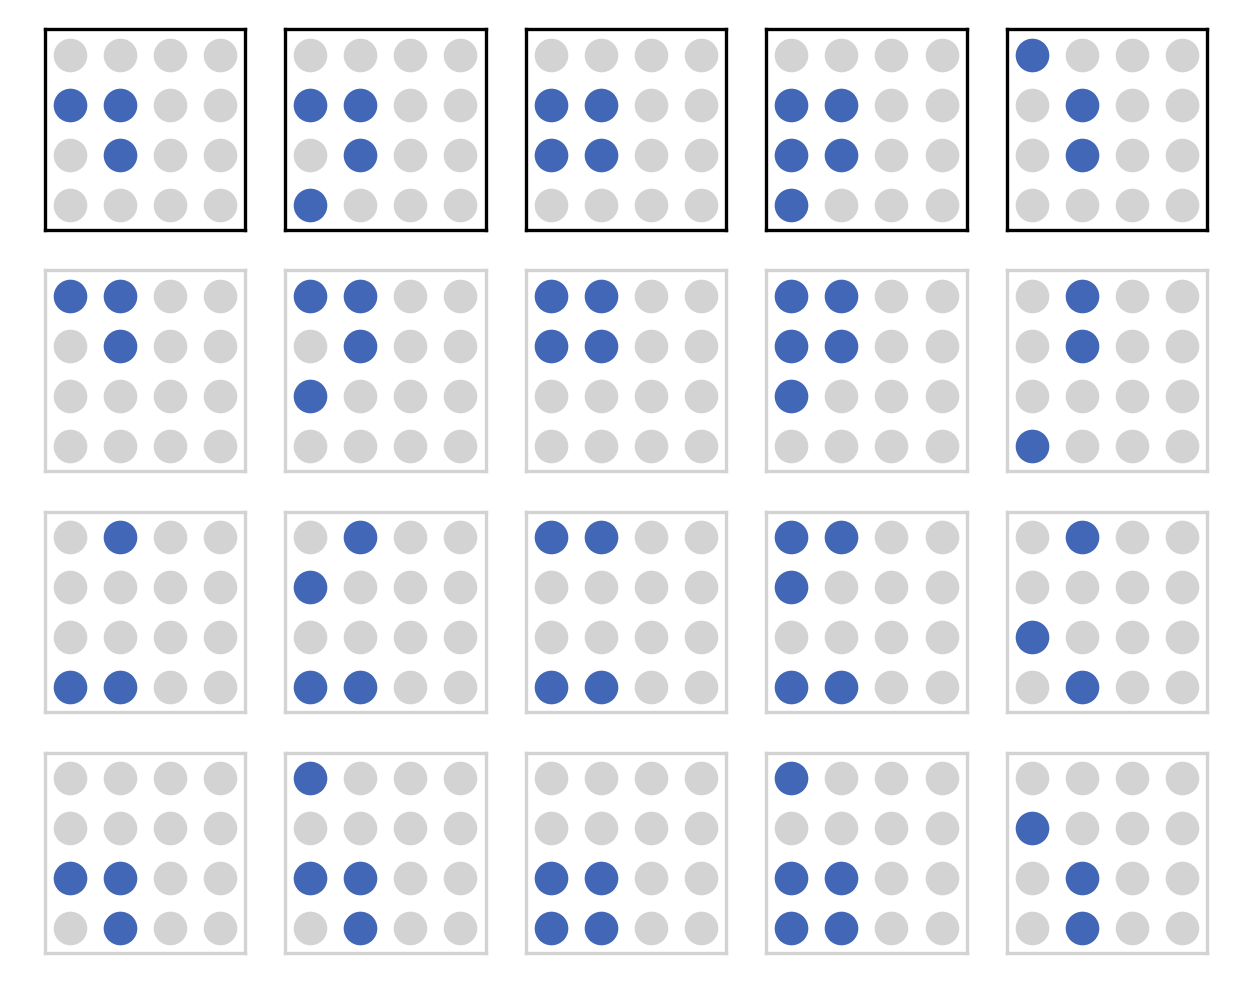

(65536, 4)


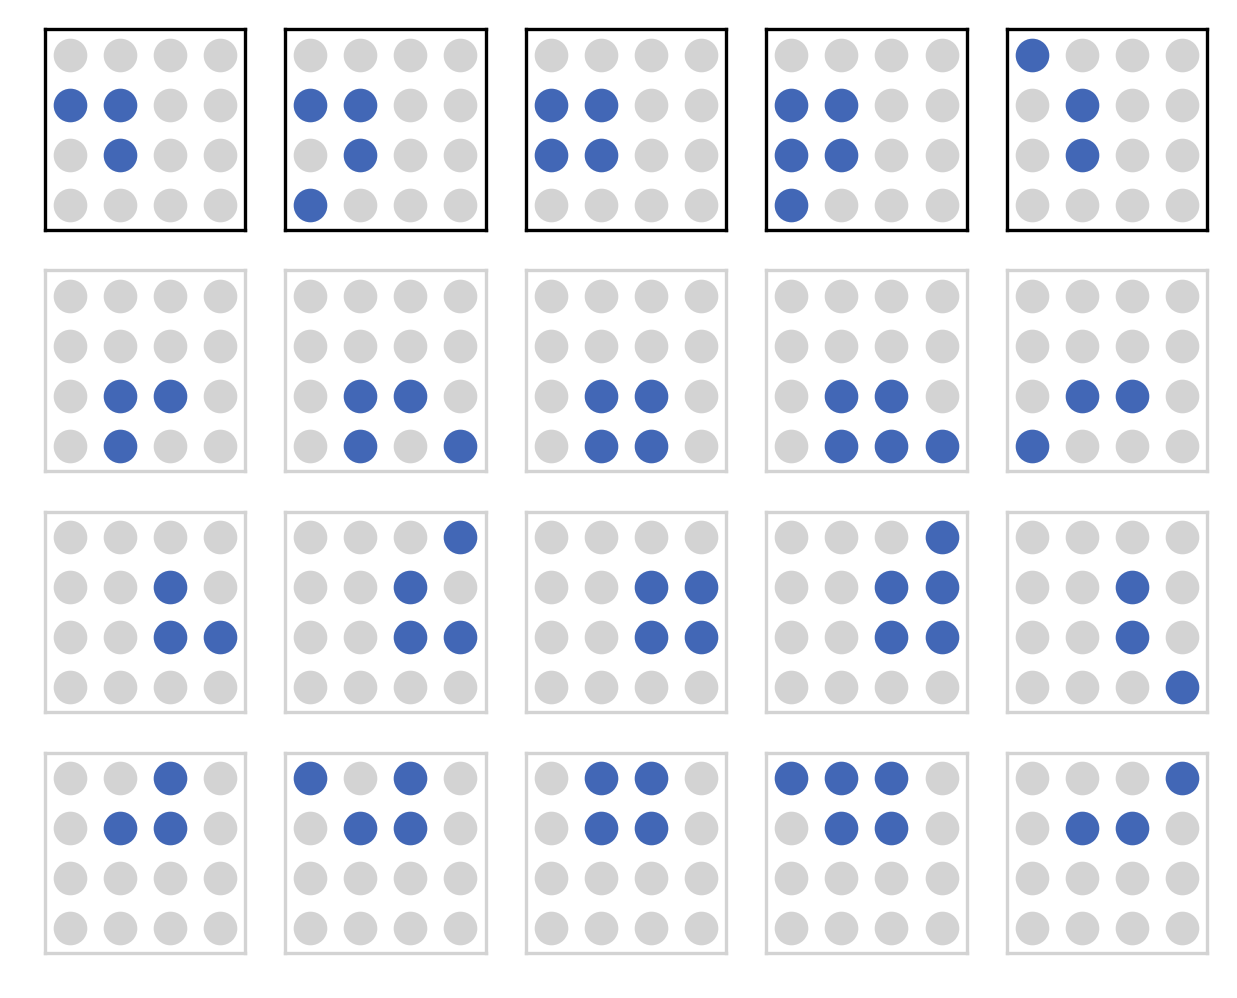

In [3]:
import matplotlib.pyplot as plt

def _imshow(ax, data, highlight = False):
  args = {'s' : 50}
  i,j = np.where(data > 0)
  ax.scatter(i,j,c = '#4267B6', **args)
  i,j = np.where(data == 0)
  ax.scatter(i,j,c = 'lightgray', **args)
  ax.set_xlim([-.5, 3.5])
  ax.set_ylim([-.5, 3.5])
  ax.set_xticks([])
  ax.set_yticks([])
  if not highlight:
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

import random

def plot_group(group, num_samples = 16):
  idx = dataset.apply(group)
  print(idx.shape)
  fig, axes = plt.subplots(idx.shape[1], num_samples, figsize = (num_samples, idx.shape[1]), dpi = 300)
  offset = 100
  for i in range(axes.shape[0]):  
    for j in range(axes.shape[1]):
      ax = axes[i, j]
      _imshow(ax, dataset[idx[offset + j, i]], highlight = i == 0) 
      
      if random.random() < .0:
        axes[i,j].remove()

plot_group(translate_x, 5)
plt.savefig('translate_x_small.pdf', transparent=True, bbox_inches = "tight")
plt.show()

plot_group(translate_y, 5)
plt.savefig('translate_y_small.pdf', transparent=True, bbox_inches = "tight")
plt.show()

plot_group(rotate, 5)
plt.savefig('rotate_small.pdf', transparent=True, bbox_inches = "tight")
plt.show()

7
25


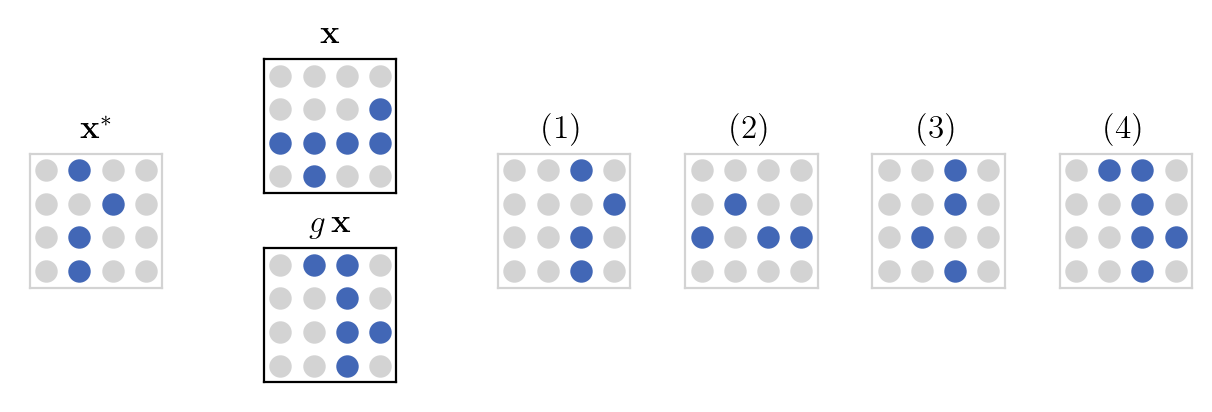

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern"
})

mosaic = """
     AAA                 
     AAA                 
CCC  AAA  DDD EEE FFF GGG
CCC       DDD EEE FFF GGG
CCC  BBB  DDD EEE FFF GGG
     BBB                 
     BBB                 
""".replace(" ", ".")

width  = len(mosaic.split('\n')[1])
height = len(mosaic.split('\n')) - 2

print(height)
print(width)

scale = .3
fig, axes = plt.subplot_mosaic(mosaic, figsize = (width*scale, height*scale), dpi = 200)

j = 1200
i = 500

titles = (
  ("C", "$\mathbf{x^*}$"),
  ("D", "(1)"),
  ("E", "(2)"),
  ("F", "(3)"),
  ("G", "(4)"),
  
  ("A", "$\mathbf{x}$"),
  ("B", "$g\,\mathbf{x}$"),
)

idx = dataset.apply(rotate)
idx_ = dataset.apply(translate_x)

for k, v in titles:
  axes[k].set_title(v)

_imshow(axes['C'], dataset[idx[j,0]])
_imshow(axes['A'], dataset[idx[i,1]], highlight = True)
_imshow(axes['B'], dataset[idx[i,2]], highlight = True)

_imshow(axes['F'], dataset[idx[j,2]])    # wrong action
_imshow(axes['G'], dataset[idx[i,2]])    # wrong content
_imshow(axes['E'], dataset[idx[j,1]])    # correct
_imshow(axes['D'], dataset[idx_[j,1]])   # wrong action

plt.savefig('riddle_2.pdf', transparent = True, bbox_inches = "tight")

In [5]:
import cebra
import torch.nn.functional as F
import torch

class Encoder(nn.Module):
  
  def __init__(self, input_dim, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.layer1 = nn.Linear(input_dim, embedding_dim)
    self.layer2 = nn.Linear(embedding_dim, embedding_dim)

  def forward(self, data):
    B = len(data)
    data = data.flatten(2)
    data = data.view(-1, data.shape[-1])
    data = self.layer1(data)
    data = F.gelu(data)
    data = self.layer2(data)
    data = F.gelu(data)
    data = data.view(B, -1, self.embedding_dim)
    return data

  
class GroupAction(nn.Module):
  
  def __init__(self, group_size, embedding_dim):
    super().__init__()
    self.embedding = nn.Parameter(.1 * torch.randn(group_size, embedding_dim))
    self.group_action = nn.Linear(embedding_dim, embedding_dim)
    
  def forward(self, data):
    # we have 65k x 4 (e.g.) to learn one group
    # then for learning this group action we store 4 embedding points
    # ref: (65k x d) + emb (4 x d) -> (65k x 4 x d)
    data = data.unsqueeze(1) + self.embedding.unsqueeze(0)
    data = self.group_action(data)
    return data

dataset = Dataset()

embedding_dim = 32

idc = np.random.choice(len(dataset.data), size = 1024)
neg_idc = np.random.choice(len(dataset.data), size = (1024, 4))

reference_samples = torch.from_numpy(dataset.data).float()
positive_indices = torch.from_numpy(dataset.apply(rotate))
  
encoder = Encoder(input_dim = 4 * 4, embedding_dim = 32)
group_action = GroupAction(group_size = 4, embedding_dim = 32)

positive_features  = encoder(reference_samples[positive_indices[idc]])
negative_features  = encoder(reference_samples[neg_idc])
reference_features = positive_features[:, 0]

def _flatten(v):
  return v.view(-1, v.shape[-1])

negative_features  = _flatten(positive_features)
positive_features  = _flatten(negative_features)
reference_features = _flatten(group_action(reference_features))

infonce = cebra.models.InfoNCE()
loss = infonce(reference_features, positive_features, negative_features)

loss

(tensor(8.3178, grad_fn=<AddBackward0>),
 tensor(0.0903, grad_fn=<MeanBackward0>),
 tensor(8.2275, grad_fn=<MeanBackward0>))